В данном блокноте производится теоретическая оценка вероятности идентификации ТС.
Для начала импортируем нужные нам библиотеки:

In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from collections import namedtuple

from model import variables
from model import snr_to_ber

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ввод необходимых параметров системы:

In [3]:
m = 1
tari = 6.25
trext = 0
MAX_BER = 0.07
MICRO = 1e-6

Расчет косвенных параметров

In [4]:
variables_by_tari = variables.get_variables_from_tari(tari)
bitrate = variables.get_bitrate(variables_by_tari.rtcal,
                                variables_by_tari.blf,
                                m)
preamble = variables.get_preamble(tari,
                                    variables_by_tari.rtcal,
                                    variables_by_tari.trcal,
                                    trext, m)
duration_from_reader = variables.get_duration_of_mes_from_reader(bitrate.reader_bitrate,
                                                                    preamble.t_full_preamble,
                                                                    preamble.t_sync_preamble)
duration_from_tag = variables.get_duration_of_mes_from_tag(preamble.tag_preamble_len,
                                                            bitrate.tag_bitrate)
duration_event = variables.get_duration_event(duration_from_reader,
                                                duration_from_tag,
                                                variables_by_tari.t1_and_t2,
                                                variables_by_tari.t1_and_t3)

In [5]:
DR = variables.DR
L = variables.AREA_LENGTH
l1 = variables.RN16_LENGTH
#N0 = 22 * 1.25
N0 = duration_from_reader.query / (tari * MICRO)
#N1 = 3 + (16+10)*3*m/DR + 3.75
N1 = (variables_by_tari.t1_and_t2 + duration_from_tag.rn16) / (tari * MICRO)
#N2 = 18*1.25 + (128+10)*3*m/DR + 3.75 + N1
N2 = N1 + (variables_by_tari.t1_and_t2 + duration_from_reader.ack + duration_from_tag.epcid) / (tari * MICRO)
#T0 = 22 * 1.25 * tari * 1e-6
T0 = duration_from_reader.query
#T1 = 3 * tari * 1e-6
T1 = variables_by_tari.t1_and_t3 / 2
T3 = T1

Получаем график мощности сигнала на разных участках действия сигнала

<AxesSubplot:xlabel='d, m', ylabel='power, dBm'>

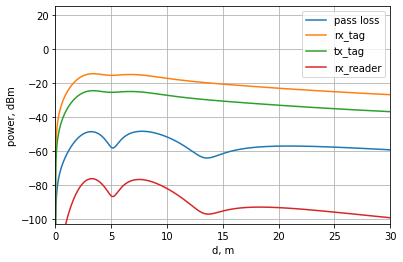

In [6]:
x = [x for x in np.arange(0.0001, 30, 0.01)]
rx_list_tag = [snr_to_ber.get_reader_power(x) for x in x]
rx_list_reader = [snr_to_ber.get_tag_power(x)-10 for x in x]
rx_power_list = [snr_to_ber.sum_of_rx_power(x) for x in x]
path_loss_reader = [snr_to_ber.lin2db(snr_to_ber.get_path_loth_for_reader(x)) for x in x]
path_loss_tag = [snr_to_ber.lin2db(snr_to_ber.get_path_loth_for_tag(x)) for x in x]
tx_tag = [snr_to_ber.get_reader_power(x)-10 for x in x]

df = pd.DataFrame()
df['x'] = x
df['pass loss'] = path_loss_tag
df['rx_tag'] = rx_list_tag
df['tx_tag'] = tx_tag
df['rx_reader'] = rx_list_reader
#df['rx_power'] = rx_power_list
#df['pass loss reader'] = path_loss_reader
#df['pass loss tag'] = path_loss_tag
df.plot(x='x', xlabel='d, m', ylabel='power, dBm', xlim=(0,30), ylim=(-103, 25), grid=True)

In [7]:
name_col = ['FM0', 'M2', 'M4', 'M8']
num_of_sym_per_bit_list = [1, 2, 4, 8]
x = [x for x in np.arange(0.0001, L, 0.01)]

ber_df = pd.DataFrame()
ber_df['x'] = x
rx_list = [snr_to_ber.get_tag_power(x)-0.5 for x in x]

def get_plot_ber(tari):
    i = 0
    variables_by_tari = variables.get_variables_from_tari(tari)
    for m in num_of_sym_per_bit_list:
        bitrate = variables.get_bitrate(variables_by_tari.rtcal,
                                    variables_by_tari.blf,
                                    m)
        preamble = variables.get_preamble(tari, variables_by_tari.rtcal,
                                        variables_by_tari.trcal,
                                        trext, m)
        snr_list = [snr_to_ber.get_snr(rx_power=rx ,m=m,
                                        preamble_duration=preamble.tag_preamble_len/bitrate.tag_bitrate,
                                        blf=variables_by_tari.blf) for rx in rx_list]

                                    
        ber = [snr_to_ber.ber_over_rayleigh(snr) for snr in snr_list]
        #ber = [snr_to_ber.ber_over_awgn(snr) for snr in snr_list]
        ber_df[name_col[i]] = ber
        i+=1
    ber_df.plot(x='x', ylim=(0,0.12), xlabel='d, m', ylabel='BER', grid=True)

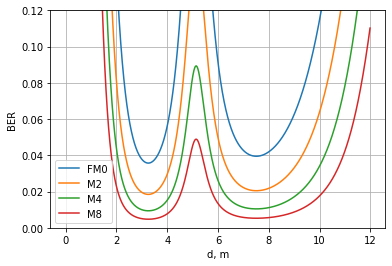

In [8]:
get_plot_ber(tari)

In [9]:
def ber_func_from_x(x):
    rx = (snr_to_ber.get_tag_power(x)-0.5)
    snr = snr_to_ber.get_snr(rx_power=rx,m=m,
                                preamble_duration=preamble.tag_preamble_len/bitrate.tag_bitrate,
                                blf=variables_by_tari.blf)
    if snr_to_ber.ber_over_rayleigh(snr) > MAX_BER:
        return MAX_BER
    return snr_to_ber.ber_over_rayleigh(snr)

In [10]:
def build_B(a1, a2, b1, b2, x1, x2, x):
    a = b1 - b2
    b = -2*(b1*x1 - b2*x2)
    c = a1 - a2 + b1*(x1**2) - b2*(x2**2)
    D = b**2 - 4*a*c
    L0 = (-b + D**0.5) / (2 * a)
    first_paralabola = a1 + b1 * (x - x1)**2
    second_parabola = a2 + b2 * (x - x2)**2
    if x < L0:
        if first_paralabola > MAX_BER:
            return MAX_BER
        return a1 + b1 * (x - x1)**2
    if second_parabola > MAX_BER:
        return MAX_BER
    return a2 + b2 * (x - x2)**2

def integ(x_opt):
    #a1, a2, b1, b2, x1, x2
    #0-a1, 1-a2, 2-b1, 3-b2, 4-x1, 5-x2
    def fn(x):
        a1 = build_B(x_opt[0], x_opt[1], x_opt[2], x_opt[3], x_opt[4], x_opt[5], x)
        a2 = ber_func_from_x(x)
        return (a1 - a2) ** 2
    return quad(fn, 0, L)[0]

In [11]:
bnds = ((0, 0.1), (0, 0.1), (0, 1), (0, 1), (0, 12), (0, 12))
x_opt_0 = (0.0361709, 0.01968352, 0.04023841, 0.01624674, 3.8756385, 7.81955679)
res_bfgs = minimize(integ, x_opt_0, method='L-BFGS-B', bounds=bnds, options={'xtol': 1e-5, 'disp': True})

<ipython-input-11-5612b6d9a978>:3: OptimizeWarning: Unknown solver options: xtol
  res_bfgs = minimize(integ, x_opt_0, method='L-BFGS-B', bounds=bnds, options={'xtol': 1e-5, 'disp': True})
<ipython-input-10-ae521b471344>:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(fn, 0, L)[0]


In [13]:
res_bfgs

      fun: 7.092113925775266e-06
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.31718592e-06,  3.27451282e-06,  2.86491361e-07,  8.76241574e-06,
       -1.29221653e-07, -3.50746351e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 364
      nit: 45
     njev: 52
   status: 0
  success: True
        x: array([0.03482474, 0.03895747, 0.04145069, 0.01334782, 3.27280615,
       7.64347827])

/home/user/Documents/my projects/rfid_project/rfid_project/model/model/snr_to_ber.py:191: RuntimeWarning: divide by zero encountered in lin2db
  tag_power = get_rx_power(x=x, path_loss=lin2db(get_path_loth_for_tag(x)), tx_power=get_reader_power(x), cable_loss=0, tag_modulation_loss=-10.0)
/home/user/Documents/my projects/rfid_project/rfid_project/model/model/snr_to_ber.py:187: RuntimeWarning: divide by zero encountered in lin2db
  reader_power = get_rx_power(x=x, path_loss=lin2db(get_path_loth_for_reader(x)), tx_power=reader_tx_power, cable_loss=-2.0, tag_modulation_loss=0)
/home/user/Documents/my projects/rfid_project/rfid_project/model/model/snr_to_ber.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  return (snr * preamble_duration * bandwidth) ** -0.5
/home/user/Documents/my projects/rfid_project/rfid_project/model/model/snr_to_ber.py:232: RuntimeWarning: invalid value encountered in cos
  return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 

<AxesSubplot:xlabel='d, m', ylabel='BER'>

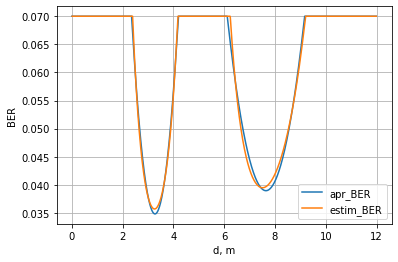

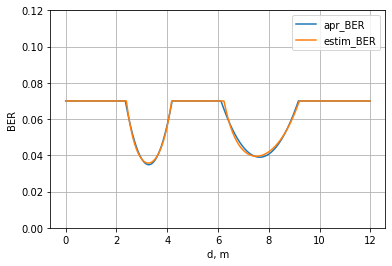

In [14]:
compare_df = pd.DataFrame()
compare_df['d, m'] = [x for x in np.arange(0, L, 0.01)]
compare_df['apr_BER'] = [build_B(res_bfgs.x[0], res_bfgs.x[1], res_bfgs.x[2], res_bfgs.x[3], res_bfgs.x[4], res_bfgs.x[5], d) for d in np.arange(0,L, 0.01)]
compare_df['estim_BER'] = [ber_func_from_x(x) for x in np.arange(0, L, 0.01)]

compare_df.plot(x='d, m', ylabel='BER', grid=True)
compare_df.plot(x='d, m', ylabel='BER', ylim=(0,0.12), grid=True)

In [16]:
def num_int(Q, Q1, Q2, V, dt, T, L, B):
    def fn(x):
        k1 = np.exp(-B(x) * Q)
        k2 = Q2 * dt * np.exp(-B(x) * Q1) 
        if k2 <= (T0 + T1 + T3):
            k2 = (T0 + T1 + T3)
        return k1 / (V*k2)
    t = quad(fn, V*T, L)[0] 
    return 1 - np.exp(-t)

def build_B_new(a1, a2, b1, b2, x1, x2):
    def fn(x):
        a = b1 - b2
        b = -2*(b1*x1 - b2*x2)
        c = a1 - a2 + b1*(x1**2) - b2*(x2**2)
        D = b**2 - 4*a*c
        L0 = (-b + D**0.5) / (2 * a)
        if x < L0:
            return a1 + b1 * (x - x1)**2
        return a2 + b2 * (x - x2)**2
    return fn

B = build_B_new(
    a1=res_bfgs.x[0],
    a2=res_bfgs.x[1],
    b1=res_bfgs.x[2],
    b2=res_bfgs.x[3],
    #L0=6.0,
    x1=res_bfgs.x[4],
    x2=res_bfgs.x[5]
)

In [20]:
def get_Q1_and_Q2(x):
    # x[0] -- L_; x[1] -- Q_;
    t = MAX_BER*(N0+N1)**2 + \
        2*(N0+N1) * (N2-N1) * (1 - np.exp(-MAX_BER*l1))/l1 + \
        (N2-N1)**2 * (1 - np.exp(-2*MAX_BER*l1)) / (2*l1) - \
        2*(N0+N1) * x[1] * (1 - np.exp(-MAX_BER*x[0])) / x[0] - \
        2*x[1] * (N2-N1) * (1 - np.exp(-MAX_BER*(x[0]+l1))) / (x[0]+l1) + \
        (x[1]**2) * (1 - np.exp(-2*MAX_BER*x[0])) / (2*x[0])
    return t

In [21]:
x0 = (100,100)
bnds = ((-500, 500), (-500, 500))
res_Q1_Q2_bfgs = minimize(get_Q1_and_Q2, x0, method='L-BFGS-B', bounds=bnds, options={'xtol': 1e-8, 'disp': True})

<ipython-input-21-9f0512ddcf61>:3: OptimizeWarning: Unknown solver options: xtol
  res_Q1_Q2_bfgs = minimize(get_Q1_and_Q2, x0, method='L-BFGS-B', bounds=bnds, options={'xtol': 1e-8, 'disp': True})


In [22]:
res_Q1_Q2_bfgs

      fun: 0.05745059413453646
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.13686838e-05,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 11
     njev: 26
   status: 0
  success: True
        x: array([  6.4956543 , 101.87061873])

<AxesSubplot:xlabel='beta', ylabel='M(t)'>

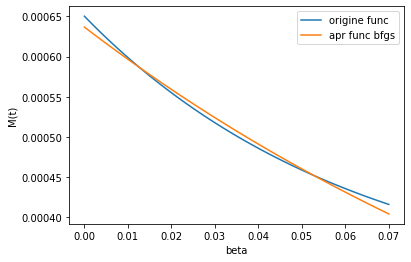

In [28]:
def test_origine_func(beta):
    return (N0 + N1 + (N2 - N1) * np.exp(-beta * l1)) * tari * MICRO
def test_apr_func(beta, res_Q1_Q2_bfgs):
    Q_ = res_Q1_Q2_bfgs.x[1]
    L_ = res_Q1_Q2_bfgs.x[0]
    return MICRO * tari * Q_ * np.exp(-beta * L_)



compafe_func = pd.DataFrame()
# df["beta"] = [beta*0.005 for beta in range(0, 41)]
compafe_func["beta"] = np.linspace(0, MAX_BER, 100)
compafe_func["origine func"] = [test_origine_func(beta) for beta in compafe_func["beta"]]
compafe_func["apr func bfgs"] = [test_apr_func(beta, res_Q1_Q2_bfgs) for beta in compafe_func["beta"]]
compafe_func.plot(x="beta", ylabel="M(t)")

<AxesSubplot:title={'center':'Probability'}, xlabel='v, km/h', ylabel='p'>

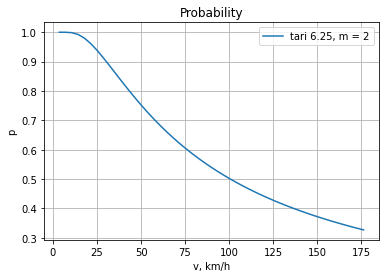

In [29]:
plot_theor = pd.DataFrame()
plot_theor['v, km/h'] = [v*3.6 for v in range(1, 50)]
plot_theor['tari 6.25, m = 2'] = [num_int(Q=16+128, Q1=res_Q1_Q2_bfgs.x[0], Q2=res_Q1_Q2_bfgs.x[1], V=v, T=(N0+N2)*tari*MICRO, dt=tari*MICRO, L=L, B=B) for v in range(1, 50)]
plot_theor.plot(x='v, km/h', ylabel='p', grid=True, title='Probability')

In [30]:
num_int(Q1=res_Q1_Q2_bfgs.x[0], Q2=res_Q1_Q2_bfgs.x[1], Q=16+128, V=50, T=(N0+N2)*tari*1e-6, dt=tari*1e-6, L=8, B=B)

0.28824495157414876

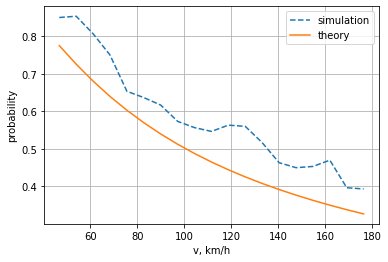

In [65]:
def num_int_with_ber_func(Q, Q1, Q2, V, dt, T, L):
    def fn(x):
        B = ber_func_from_x(x)
        k1 = np.exp(-B * Q)
        k2 = Q2 * dt * np.exp(-B * Q1) 
        if k2 <= (T0 + T1 + T3):
            k2 = (T0 + T1 + T3)
        return k1 / (V*k2)
    t = quad(fn, V*T, L)[0] 
    return (1 - np.exp(-t))

fig, ax = plt.subplots()

plot_theor_ber_func = pd.DataFrame()
plot_theor_ber_func['v, km/h'] = [v*3.6 for v in range(13, 50, 2)]
#plot_theor_ber_func['prob without parabols'] = [num_int_with_ber_func(Q=16+128, Q1=res_Q1_Q2_bfgs.x[0], Q2=res_Q1_Q2_bfgs.x[1], V=v, T=(N0+N2)*tari*MICRO, dt=tari*MICRO, L=L) for v in range(13, 50, 2)]
plot_theor_ber_func['prob with parabols'] = [num_int(Q=16+128, Q1=res_Q1_Q2_bfgs.x[0], Q2=res_Q1_Q2_bfgs.x[1], V=v, T=(N0+N2)*tari*MICRO, dt=tari*MICRO, L=L, B=B) for v in range(13, 50, 2)]
plot_theor_ber_func['exp'] = data_from_exp['probability']
#plot_theor_ber_func.plot(x='v, km/h', ylabel='p', grid=True, title='Probability')
exp_dot = ax.plot(list(plot_theor_ber_func['v, km/h']), list(plot_theor_ber_func['exp']), linestyle = '--', label='simulation')
theor_line = ax.plot(list(plot_theor_ber_func['v, km/h']), list(plot_theor_ber_func['prob with parabols']), label='theory')
ax.grid()
ax.legend()
ax.set_xlabel('v, km/h')
ax.set_ylabel('probability')
fig.savefig('tari625_m1')

/home/user/Documents/my projects/rfid_project/rfid_project/model/model/snr_to_ber.py:191: RuntimeWarning: divide by zero encountered in lin2db
  tag_power = get_rx_power(x=x, path_loss=lin2db(get_path_loth_for_tag(x)), tx_power=get_reader_power(x), cable_loss=0, tag_modulation_loss=-10.0)
/home/user/Documents/my projects/rfid_project/rfid_project/model/model/snr_to_ber.py:187: RuntimeWarning: divide by zero encountered in lin2db
  reader_power = get_rx_power(x=x, path_loss=lin2db(get_path_loth_for_reader(x)), tx_power=reader_tx_power, cable_loss=-2.0, tag_modulation_loss=0)
/home/user/Documents/my projects/rfid_project/rfid_project/model/model/snr_to_ber.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  return (snr * preamble_duration * bandwidth) ** -0.5
/home/user/Documents/my projects/rfid_project/rfid_project/model/model/snr_to_ber.py:232: RuntimeWarning: invalid value encountered in cos
  return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 

<AxesSubplot:xlabel='x'>

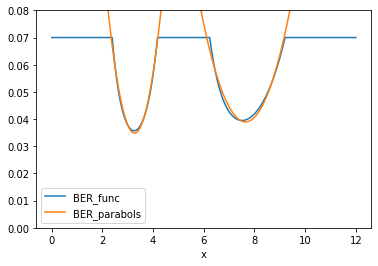

In [46]:
x_ = []
b_ = []
def fn(x):
    B = ber_func_from_x(x)
    #x_.append(x)
    #b_.append(B)
    return B

check_ber_x = pd.DataFrame()
check_ber_x['x'] = np.linspace(0,L,1000)
check_ber_x['BER_func'] = [fn(x) for x in check_ber_x['x']]
check_ber_x['BER_parabols'] = [B(x) for x in check_ber_x['x']]
check_ber_x.plot(x='x', ylim=(0, 0.08))

In [47]:
def check_t_m(x, Q, Q1, Q2, dt,):
    B = ber_func_from_x(x)
    #k1 = np.exp(-B * Q)
    k2 = Q2 * dt * np.exp(-B * Q1) 
    if k2 <= (T0 + T1 + T3):
        k2 = (T0 + T1 + T3)
    return k2

t_m = [check_t_m(x, Q=16+128, Q1=res_Q1_Q2_bfgs.x[0], Q2=res_Q1_Q2_bfgs.x[1], dt=tari*MICRO) for x in np.arange(0.01, L, 0.01)]
t_m = np.array(t_m)
number_rounds = L / (50 * t_m.mean())
print(number_rounds)
print(t_m.mean())

558.8382954529653
0.0004294623363373272


In [32]:
data_from_exp = pd.DataFrame(data=pd.read_csv('data/tari_625_m1_tid_off.csv'))

In [51]:
list(data_from_exp['probability'])

[0.85,
 0.8533333333333333,
 0.8066666666666668,
 0.75,
 0.6533333333333333,
 0.6366666666666667,
 0.6166666666666667,
 0.5733333333333333,
 0.5566666666666668,
 0.5466666666666666,
 0.5633333333333334,
 0.56,
 0.5166666666666666,
 0.4633333333333334,
 0.45,
 0.4533333333333333,
 0.4699999999999998,
 0.3966666666666666,
 0.3933333333333333]